In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [42]:
# Function to get NIFTY50 data
def get_nifty50_data(start_date, end_date):
    data = yf.download('^NSEI', start=start_date, end=end_date)
    return data['Close']


In [49]:
# Function to choose the next action using epsilon-greedy policy
def choose_action(state, q_values, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        # Randomly choose an action
        return np.random.choice([0, 1])  # 0: Buy, 1: Sell
    else:
        # Choose the action with the highest Q-value
        return np.argmax(q_values[state])

In [50]:
# Q-learning algorithm for NIFTY50 trading
def q_learning_nifty50(data, initial_balance=10000, num_episodes=1000, epsilon=0.3):
    # Normalize the data for better convergence
    data = data / data.iloc[0]

    # Initialize Q-values
    num_states = 1000  # Number of states based on portfolio value and return
    q_values = np.zeros((num_states, 2))  # 2 actions (buy, sell)

    # Track portfolio value for each episode
    portfolio_values = []

    for episode in range(num_episodes):
        balance = initial_balance
        shares = 0
        total_reward = 0

        for i in range(len(data) - 1):
            # Calculate the current state index based on portfolio value and return
            state = int((balance / initial_balance) * 100) * 10 + int((data.iloc[i + 1] - data.iloc[i]) * 100)

            # Clip the state index to valid bounds
            state = max(0, min(state, num_states - 1))

            # Choose action based on epsilon-greedy policy
            action = choose_action(state, q_values, epsilon)

            # Calculate the reward for the action
            reward = (data.iloc[i + 1] - data.iloc[i]) * shares

            # Update balance and shares based on the action
            if action == 0:  # Buy
                shares_to_buy = int(balance / data.iloc[i + 1])
                balance -= shares_to_buy * data.iloc[i + 1]
                shares += shares_to_buy
            else:  # Sell
                balance += shares * data.iloc[i + 1]
                shares = 0

            # Get the next state and update the Q-value
            next_state = int((balance / initial_balance) * 100) * 10 + int((data.iloc[i + 1] - data.iloc[i]) * 100)
            next_state = max(0, min(next_state, num_states - 1))

            # Q-learning update equation
            q_values[state, action] = q_values[state, action] + learning_rate * (
                reward + discount_factor * np.max(q_values[next_state, :]) - q_values[state, action]
            )

            # Track total reward for this episode
            total_reward += reward

        # Append the final portfolio value for this episode
        portfolio_values.append(balance + shares * data.iloc[-1])

    return portfolio_values, q_values

In [52]:
# Set Q-learning parameters
learning_rate = 0.1
discount_factor = 0.9
num_episodes = 500
epsilon = 0.3

In [53]:
# Fetch NIFTY50 data
start_date = '2010-01-01'
end_date = '2019-01-01'
nifty50_data = get_nifty50_data(start_date, end_date)
# Convert the Series to a DataFrame
nifty50_data = pd.DataFrame(nifty50_data, columns=['Close'])

[*********************100%***********************]  1 of 1 completed


In [54]:
nifty50_data.head

<bound method NDFrame.head of                    Close
Date                    
2010-01-04   5232.200195
2010-01-05   5277.899902
2010-01-06   5281.799805
2010-01-07   5263.100098
2010-01-08   5244.750000
...                  ...
2018-12-24  10663.500000
2018-12-26  10729.849609
2018-12-27  10779.799805
2018-12-28  10859.900391
2018-12-31  10862.549805

[2202 rows x 1 columns]>

In [55]:
# Run Q-learning algorithm
portfolio_values, _ = q_learning_nifty50(nifty50_data, num_episodes=num_episodes, epsilon=epsilon)

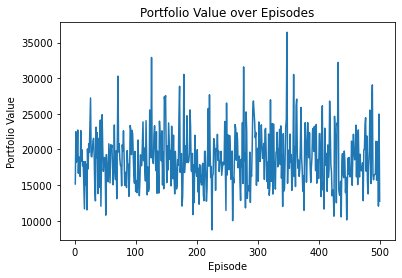

In [56]:
# Plot portfolio value over episodes
plt.plot(range(1, num_episodes + 1), portfolio_values)
plt.xlabel('Episode')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value over Episodes')
plt.show()